In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer

qt1 = QuantileTransformer(output_distribution='normal', random_state=42)

def preprocess_csv(csv_file, output_file, train_min=None, train_max=None, is_training=True):
    # Load the data
    data_frame = pd.read_csv(csv_file)

    # Identify target columns
    target_columns = data_frame.columns[164:]  # Assuming targets are from the 165th column onwards
    bioclimatic_columns = data_frame.columns[1:164]  # Bioclimatic variables from columns 1 to 163

    print(target_columns.shape)
    print(bioclimatic_columns.shape)

    # Log10 transformation of the target values (still invalid because negative numbers inside)
    # data_frame[target_columns] = data_frame[target_columns].apply(np.log10)

    # If it is the training set, calculate min and max values for normalization
    if is_training:
        means = []
        stds = []
        for col in target_columns:
            means.append(data_frame[col].mean())
            stds.append(data_frame[col].std())
        for i, col in enumerate(target_columns):
            data_frame = data_frame[(data_frame[col] >= means[i] - 3 * stds[i]) & (data_frame[col] <= means[i] + 3 * stds[i])]

        # Calculate min and max values for normalization after removing outliers
        train_min = data_frame[bioclimatic_columns].min()
        train_max = data_frame[bioclimatic_columns].max()
        result_min = data_frame[target_columns].min()
        result_max = data_frame[target_columns].max()

        data_frame[target_columns] = (data_frame[target_columns] - result_min) / (result_max - result_min)
        data_frame[bioclimatic_columns] = qt1.fit_transform(data_frame[bioclimatic_columns])

    else:
        # Use the training set min and max values for normalization
        data_frame[bioclimatic_columns] = qt1.transform(data_frame[bioclimatic_columns])

    # Save the preprocessed data to a new CSV file with headers
    data_frame.to_csv(output_file, index=False)
    return train_min, train_max


train_min, train_max = preprocess_csv('data/train.csv', 'data/train_preprocessed_qt+2.csv', is_training=True)

preprocess_csv('data/test.csv', 'data/test_preprocessed_qt+2.csv', train_min, train_max, is_training=False)
print("Preprocessing completed successfully.")


(6,)
(163,)
(0,)
(163,)
Preprocessing completed successfully.


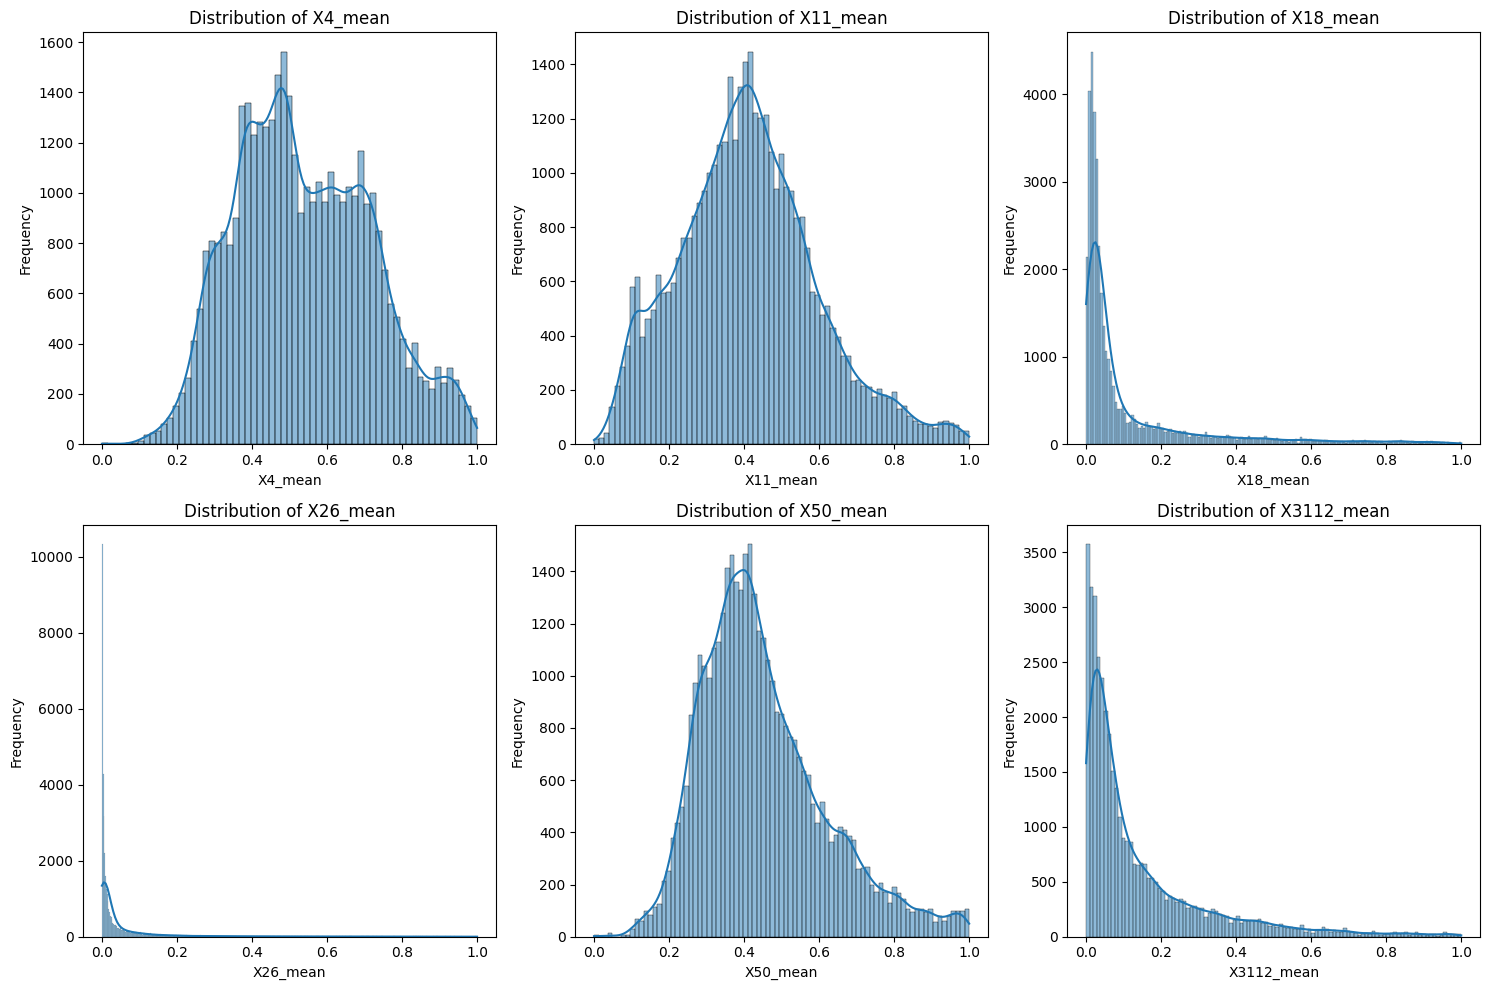

In [8]:
from matplotlib import pyplot as plt


def plot_target_distributions(data_frame, target_columns):
    num_columns = len(target_columns)
    num_rows = (num_columns + 1) // 3  # Assuming 3 columns per row

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))  # Adjust figsize as needed
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

    for idx, col in enumerate(target_columns):
        sns.histplot(data_frame[col], kde=True, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

    # Hide any unused subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


data_frame = pd.read_csv('data/train_preprocessed_qt+2.csv')
target_columns = data_frame.columns[164:]  # Assuming targets are from the 165th column onwards

# Plot the distribution of each target column
plot_target_distributions(data_frame, target_columns)

In [4]:
def identify_nans(data_frame):
    nan_locs = data_frame.isna()
    nan_rows_cols = nan_locs.any(axis=1), nan_locs.any(axis=0)

    nan_rows = data_frame[nan_rows_cols[0]]
    nan_cols = data_frame.loc[:, nan_rows_cols[1]]
    return nan_rows, nan_cols
data_frame = pd.read_csv('data/test_preprocessed_qt+3.csv')

if data_frame.isna().sum().sum() > 0:
    print("Warning: The preprocessed data contains NaN values.")
    nan_rows, nan_cols = identify_nans(data_frame)
    print("Rows with NaNs:\n", nan_rows)
    print("Columns with NaNs:\n", nan_cols)
else:
    print("The preprocessed data is valid with no NaN values.")

The preprocessed data is valid with no NaN values.
